In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Tabla de contenidos**
***
Redes Neuronales (MLP)
1.  Modelo 1 (baseline)

    1.1. Creación del modelo baseline

    1.2. Evaluación del modelo baseline

2.  Modelo 2

    2.1. Creación del modelo 2

    2.2. Evaluación del modelo 2
    
3.  Modelo 3

    3.1. Creación del modelo 3

    3.2. Evaluación del modelo 3

4.  Evaluación general y conclusiones

***

# **Redes Neuronales** (MLP)

Un **modelo MLP** *(perceptrón multicapa)* es una clase de red neuronal que se caracteriza por estar inspirado en las neuronas biológicas y su principal cometido es la **clasificación de datos**.

En nuestro caso vamos a utilizar un modelo MLP para predecir y clasificar **qué tipo de crimen es más posible que le ocurra a una víctima** dependiendo de los siguientes datos:

In [52]:
X_train = pd.read_csv("../../../data/x_train.csv")
X_test = pd.read_csv("../../../data/x_test.csv")
y_train = pd.read_csv("../../../data/y_train.csv")
y_test = pd.read_csv("../../../data/y_test.csv")

Nuestras **variables predictoras** son:

In [53]:
print(f"Variables predictoras:\n")
print(X_train.describe().T)

Variables predictoras:

                                                    count unique    top   freq
ager_18-24                                          44702      2  False  36809
ager_25-34                                          44702      2  False  35387
ager_35-49                                          44702      2  False  33479
ager_50-64                                          44702      2  False  37721
ager_65+                                            44702      2  False  42535
sex_Male                                            44702      2   True  22657
race_ethnicity_Non-Hispanic American Indian/Ala...  44702      2  False  44208
race_ethnicity_Non-Hispanic Asian/Native Hawaii...  44702      2  False  43616
race_ethnicity_Non-Hispanic black                   44702      2  False  39169
race_ethnicity_Non-Hispanic more than one race      44702      2  False  43735
race_ethnicity_Non-Hispanic white                   44702      2   True  30622
hincome1_$25,000 to $34,999 

En este caso la **variable a predecir** seria *'newoff'*:

In [54]:
print(f"Variable a predecir:\n")
print(f"{y_train.info()}\n")
print(f"Valores en la variable a predecir:\n")
print(y_train['newoff'].value_counts())

Variable a predecir:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44702 entries, 0 to 44701
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   newoff  44702 non-null  int64
dtypes: int64(1)
memory usage: 349.4 KB
None

Valores en la variable a predecir:

newoff
4    27850
3     8460
2     4634
1     2440
5     1318
Name: count, dtype: int64


Nuestros DataFrames tiene la siguiente **dimensionalidad**:

In [55]:
print("Dimensionalidad de X_train:", X_train.shape)
print("Dimensionalidad de y_train:", y_train.shape)
print("Dimensionalidad de X_test:", X_test.shape)
print("Dimensionalidad de y_test:", y_test.shape)

Dimensionalidad de X_train: (44702, 42)
Dimensionalidad de y_train: (44702, 1)
Dimensionalidad de X_test: (11176, 42)
Dimensionalidad de y_test: (11176, 1)


Teniendo esto en cuenta podemos hacer las siguientes presunciones:

1. La dimensionalidad de la capa de entrada siempre va a ser:  
$$
n_{\text{features}} = X_{\text{train}}.shape[1]
$$


In [56]:
print(f"Dimensionalidad de la capa de entrada: ({X_train.shape[1]},)")

Dimensionalidad de la capa de entrada: (42,)


2. Las capas ocultas utilizarán la función de activación *'ReLU'*:
$$
\text{ReLU}(x) = \max(0, x)
$$


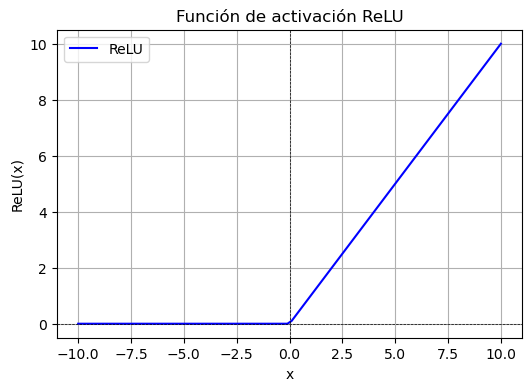

In [57]:
plt.figure(figsize=(6,4))
plt.title("Función de activación ReLU")
x = np.linspace(-10, 10, 100)
y = np.maximum(0, x)
plt.plot(x, y, label='ReLU', color='blue')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.legend()
plt.grid()
plt.show()

3. Como estamos haciendo una red neuronal para clasificación multiclase la función de activación de la capa de salida sera *'Softmax'*:
$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}, \quad i = 1, \dots, K
$$


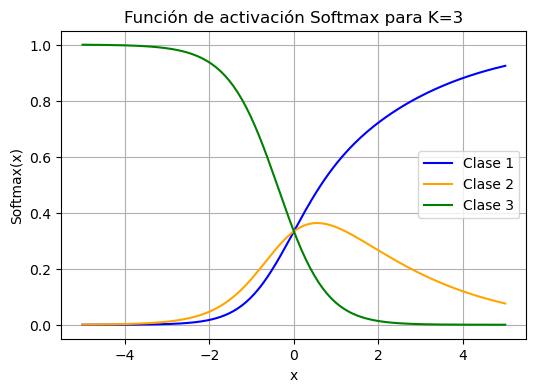

In [58]:
plt.figure(figsize=(6,4))
plt.title("Función de activación Softmax para K=3")

x = np.linspace(-5, 5, 200)

# Definimos tres "neuronas" con pendientes distintas
z1 = x
z2 = 0.5 * x
z3 = -x

# Calculamos softmax para cada punto x
exp_z = np.exp(np.vstack([z1, z2, z3]))
softmax = exp_z / np.sum(exp_z, axis=0)

# Graficamos
plt.plot(x, softmax[0], label='Clase 1', color='blue')
plt.plot(x, softmax[1], label='Clase 2', color='orange')
plt.plot(x, softmax[2], label='Clase 3', color='green')
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.legend()
plt.grid(True)
plt.show()

4. Como pasamos los resultados en forma de índice y no en OHE la función de pérdida utilizada será la entropía cruzada categórica escasa (*sparse categorical cross-entropy*):
$$
L = -\frac{1}{N} \sum_{i=1}^{N} \log p_{i, y_i}
$$

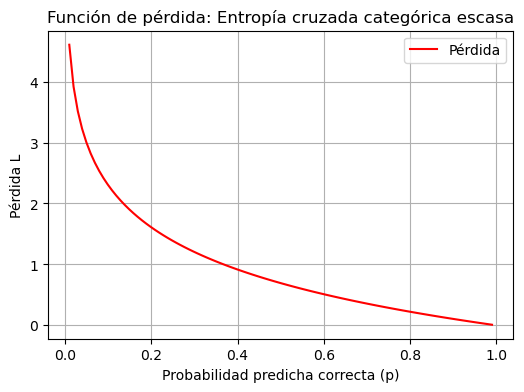

In [59]:
plt.figure(figsize=(6,4))
plt.title("Función de pérdida: Entropía cruzada categórica escasa")
p = np.linspace(0.01, 0.99, 100)
L = -np.log(p)
plt.plot(p, L, label='Pérdida', color='red')
plt.xlabel('Probabilidad predicha correcta (p)')
plt.ylabel('Pérdida L')
plt.legend()
plt.grid()
plt.show()

## 1. Modelo 1 (baseline)

El primer modelo lo vamos a usar como una base para los otros, por esta razón vamos a crearlo con una estructura muy simple.  
En este caso nuestro modelo ***baseline*** se compone de:

Tabla de especificaciones modelo baseline:
| Especificación | Detalle | Valor Usado |
| :---: | :--- | :--- |
| **Arquitectura** | Capas Densas | 2 Capas (1 Oculta, 1 Salida) |
| **Capa Oculta** | Número de neuronas | **32** neuronas |
| **Activación (Oculta)** | Tipo de activación | **ReLU** |
| **Capa de Salida** | Tipo de Clasificación | **5** neuronas con **Softmax** |
| **Regularización** | Dropout / L2 | **No** se utiliza |
| **Normalización** | BatchNormalization | **No** se utiliza |
| **Manejo de Desbalance** | Técnica utilizada | **No** se utiliza |
| **Optimizador** | Tipo | **Adam** (configuración por defecto) |
| **Función de Pérdida** | Loss Function | **`sparse_categorical_crossentropy`** |
| **Métrica de Monitoreo** | Métrica Clave | **Accuracy** |
| **EarlyStopping** | Utilizado | **No** se utiliza |
| **Épocas** | Número de iteraciones | **20** |
| **Tamaño de Lote (Batch)** | Batch size | **32** |
| **Split de Validación** | Porcentaje de `validation_split` | **0.2** (20% de `X_train`) |
| **Datos de Entrenamiento** | Datos fuente | Datos Originales (`X_train`) |

### 1.1. Creación modelo baseline


In [66]:
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

#Pasar de 1-5 a 0-4
y_train = y_train-1
y_test = y_test-1

# Modelo simple
model_baseline = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation="relu"),
    Dense(5, activation="softmax")
])

model_baseline.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_baseline = model_baseline.fit(X_train, y_train,
                                   validation_split=0.2,
                                   epochs=20,
                                   batch_size=32,
                                   verbose=1)

Epoch 1/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6157 - loss: 1.0841 - val_accuracy: 0.6247 - val_loss: 1.0461
Epoch 2/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6225 - loss: 1.0381 - val_accuracy: 0.6272 - val_loss: 1.0375
Epoch 3/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6231 - loss: 1.0322 - val_accuracy: 0.6274 - val_loss: 1.0334
Epoch 4/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6236 - loss: 1.0289 - val_accuracy: 0.6258 - val_loss: 1.0331
Epoch 5/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6241 - loss: 1.0266 - val_accuracy: 0.6263 - val_loss: 1.0332
Epoch 6/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6249 - loss: 1.0240 - val_accuracy: 0.6259 - val_loss: 1.0323
Epoch 7/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6250 - loss: 1.0226 - val_accuracy: 0.6272 - val_loss: 1.0313
Epoch 8/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6251 - loss: 1.0209 - 

### 1.2. Evaluación modelo baseline

Train Accuracy: 0.6275 (62.75%)
Train Loss: 1.0108
Test Accuracy: 0.6233 (62.33%)
Test Loss: 1.0355


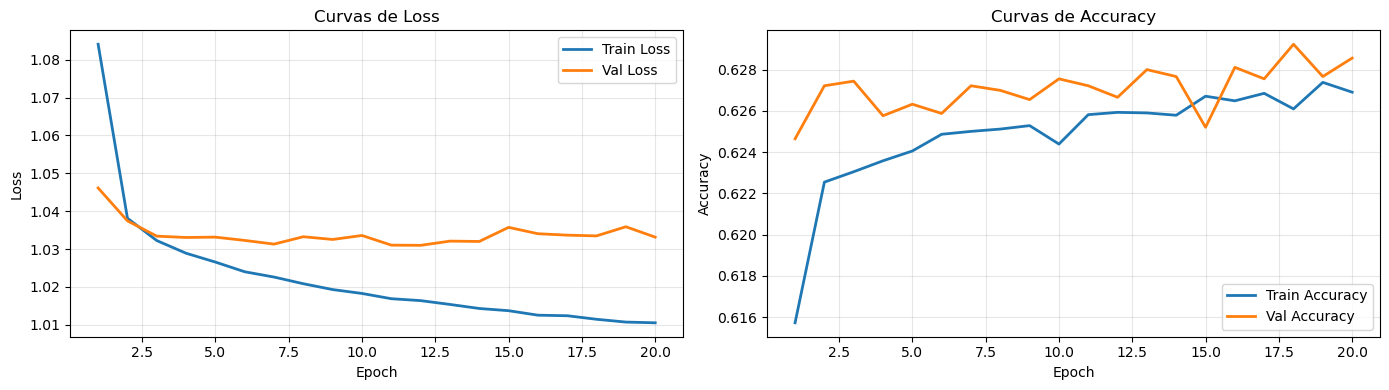

In [67]:
# Evaluar train

train_loss, train_acc = model_baseline.evaluate(X_train, y_train, verbose=0)

print(f"Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Train Loss: {train_loss:.4f}")

# Evaluar test

test_loss, test_acc = model_baseline.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Visualización de curvas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Crear rango de epochs (1 a 20, no 0 a 19)
epochs = range(1, len(history_baseline.history['loss']) + 1)

# Loss
ax1.plot(epochs, history_baseline.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs, history_baseline.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curvas de Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy
ax2.plot(epochs, history_baseline.history['accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(epochs, history_baseline.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Curvas de Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Viendo los **valores** de accuracy y loss en train y en test podemos obsevar que son **muy parecidos en los dos**. Esto nos dice que el modelo **generaliza bien** y que no sufre de overfitting pero el **rendimiento global** sigue siendo **muy bajo** (entorno al 62%).  

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


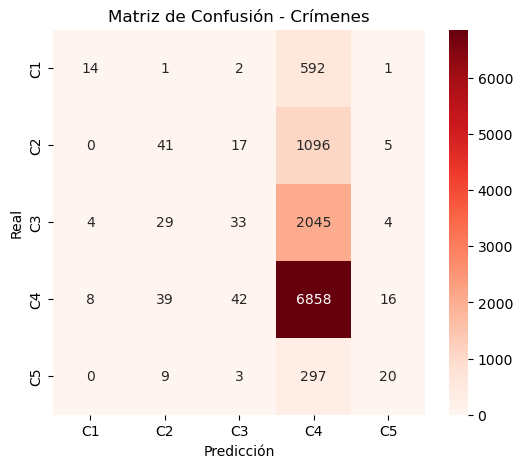


 Classification Report:
              precision    recall  f1-score   support

          C1       0.54      0.02      0.04       610
          C2       0.34      0.04      0.06      1159
          C3       0.34      0.02      0.03      2115
          C4       0.63      0.98      0.77      6963
          C5       0.43      0.06      0.11       329

    accuracy                           0.62     11176
   macro avg       0.46      0.22      0.20     11176
weighted avg       0.53      0.62      0.50     11176



In [68]:
# Matriz de confusión
y_pred_crime = model_baseline.predict(X_test)
y_pred_crime_classes = np.argmax(y_pred_crime, axis=1)

cm = confusion_matrix(y_test, y_pred_crime_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[f"C{i+1}" for i in range(5)],
            yticklabels=[f"C{i+1}" for i in range(5)])
plt.title('Matriz de Confusión - Crímenes')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

print("\n Classification Report:")
print(classification_report(y_test, y_pred_crime_classes, 
                          target_names=[f"C{i+1}" for i in range(5)]))

Analizando el classification report podemos sacar otras conclusiones. Podemos ver como el modelo tiene un claro **sesgo hacia la clase 4** (C4) y que en la mayoría de las ocasiones decide predecir ese resultado sin tener en cuenta las demás clases. Esto se puede deber a que tenemos un **desbalanceo en las clases** (tenemos muchos mas datos de la clase 4 que de las demás) y esto hace que el modelo crea que la **solución mas sencilla es predecir la clase 4** sin importar que datos se le den.  

Para intenrar mejorar el modelo podemos intentar lo siguiente:
- Cambiar la metrica a *'f1-score'* de evaluación para combatir las clases desbalanceadas.
- Usar *'class_weights'* en la función de perdida para penalizar más los errores en las clases minoritarias.

## 2. Modelo 2

Tabla de especificaciones modelo 2:
| Especificación | Detalle | Valor Usado |
| :---: | :--- | :--- |
| **Arquitectura** | Capas Densas/Activación | 4 Capas (1 Input, 3 Ocultas) |
| **Capas Ocultas** | Número de neuronas | 128, 64, 32 neuronas |
| **Activación (Ocultas)** | Tipo de activación | **ReLU** |
| **Capa de Salida** | Tipo de Clasificación | 5 neuronas (Clases) con **Softmax** |
| **Regularización** | Dropout / L2 | **No** se utiliza |
| **Normalización** | BatchNormalization | **No** se utiliza |
| **Manejo de Desbalance** | Técnica utilizada | **`class_weight`** (pesos de clase balanceados) |
| **Optimizador** | Tipo | **Adam** (configuración por defecto) |
| **Función de Pérdida** | Loss Function | **`sparse_categorical_crossentropy`** |
| **Métrica de Monitoreo** | Métrica Clave | **F1-Score (weighted)** (a través de Callback) |
| **EarlyStopping** | Utilizado | **No** se utiliza |
| **Épocas** | Número de iteraciones | **20** |
| **Tamaño de Lote (Batch)** | Batch size | **32** |
| **Datos de Entrenamiento** | Datos fuente | Datos Originales (`X_train`) |

### 2.1. Creación modelo 2

In [69]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import Callback

# --- Callback para F1-score ponderado ---
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_val, verbose=0), axis=1)
        f1 = f1_score(self.y_val, y_pred, average='weighted')
        self.f1_scores.append(f1)
        print(f" — val_f1: {f1:.4f}")

# --- Calcular pesos por clase ---
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train["newoff"].values),
    y=y_train["newoff"].values
)
class_weight_dict = dict(enumerate(class_weights))

# --- Modelo ---
model2 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')  # 6 clases
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[]  # F1-score con callback
)

# --- Entrenamiento ---
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))

history_model2 = model2.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[f1_callback],
    verbose=1
)

Epoch 1/20
1384/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5036 — val_f1: 0.3423
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4549 - val_loss: 1.4878
Epoch 2/20
1390/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4043 — val_f1: 0.3123
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.4091 - val_loss: 1.5468
Epoch 3/20
1396/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3793 — val_f1: 0.3198
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3930 - val_loss: 1.5035
Epoch 4/20
1380/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3770 — val_f1: 0.2987
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3769 - val_loss: 1.5030
Epoch 5/20
1376/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3548 — val_f1: 0.3560
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3643 - val_loss: 1.4253
Epoch 6/20
1373/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3470 — val_f1: 0.3495
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3478 - val_loss: 1.4411
Epoch 7/20
1380/1397 ━

### 2.2. Evaluación modelo 2

Train Loss: 1.3950
Test Loss: 1.5800


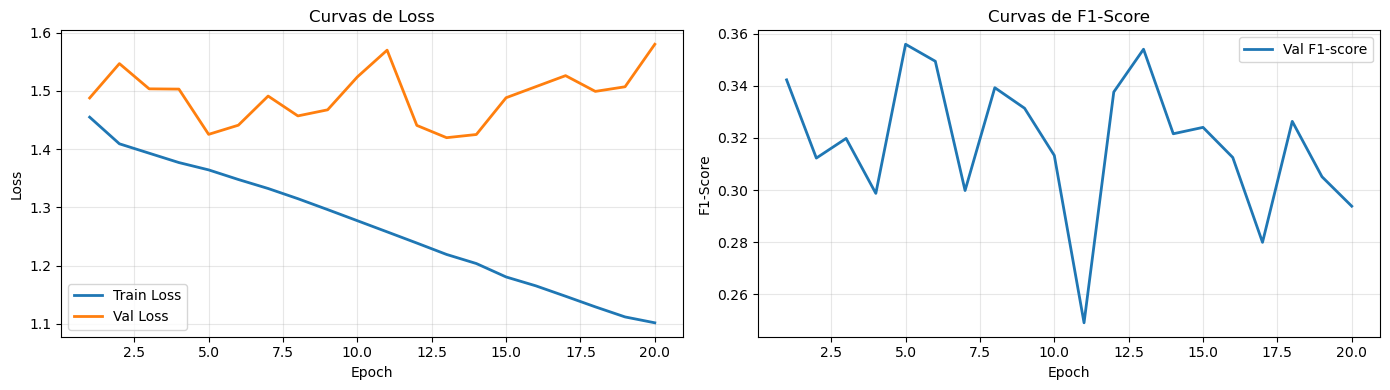

In [71]:
# Evaluar train

train_loss = model2.evaluate(X_train, y_train, verbose=0)

print(f"Train Loss: {train_loss:.4f}")

# Evaluar test

test_loss = model2.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")

# Visualización de curvas de entrenamiento
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Crear rango de epochs (1 a 20, no 0 a 19)
epochs = range(1, len(history_model2.history['loss']) + 1)

# Loss
ax1.plot(epochs, history_model2.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs, history_model2.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curvas de Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, f1_callback.f1_scores, label='Val F1-score', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-Score')
ax2.set_title('Curvas de F1-Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Viendo el gráfico de *loss* podemos decir que ahora tenemos **overfitting** ya que podemos ver como en train la pérdida baja según avanzan las épocas pero en val sube, esto quiere decir que el modelo **no generaliza bien**.  

En el gráfico de *f1-score* podemos ver como **varía constantemente** entre las épocas. Esto nos dice que el modelo no consigue hacer una clasificación precisa y hay **alguna clase que domina las predicciones**.

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


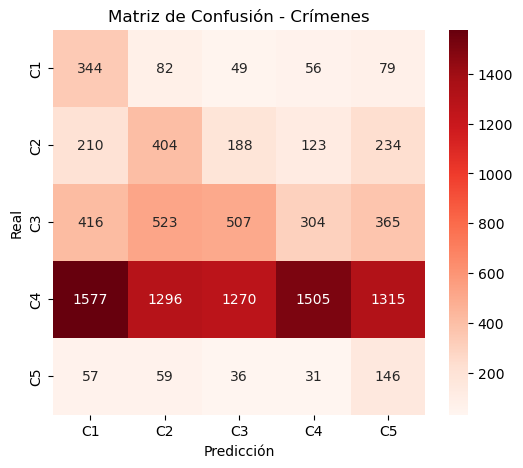


 Classification Report:
              precision    recall  f1-score   support

          C1       0.13      0.56      0.21       610
          C2       0.17      0.35      0.23      1159
          C3       0.25      0.24      0.24      2115
          C4       0.75      0.22      0.34      6963
          C5       0.07      0.44      0.12       329

    accuracy                           0.26     11176
   macro avg       0.27      0.36      0.23     11176
weighted avg       0.54      0.26      0.29     11176



In [72]:
# Matriz de confusión
y_pred_crime = model2.predict(X_test)
y_pred_crime_classes = np.argmax(y_pred_crime, axis=1)

cm = confusion_matrix(y_test, y_pred_crime_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[f"C{i+1}" for i in range(5)],
            yticklabels=[f"C{i+1}" for i in range(5)])
plt.title('Matriz de Confusión - Crímenes')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

print("\n Classification Report:")
print(classification_report(y_test, y_pred_crime_classes, 
                          target_names=[f"C{i+1}" for i in range(5)]))

En la matriz de confusión podemos ver que la **clase 4 (C4) sigue dominando las predicciones** y las otras clases son predichas de forma muy dispersa, con esto podemos deducir que **aun ajustando los pesos de las clases el modelo sigue teniendo un sesgo hacia la clase mayoritaria**.  

Para intentar mejorar el modelo vamos a hacer los siguientes cambios en el Modelo 3:

- Añadir Dropout para evitar overfitting
- Aumentar las épocas e implementar EarlyStopping para detener el entrenamiento en caso de que empeore
- Implementar SMOTETomek para intentar minimizar aun más el desbalanceo de clases
- Implementar BatchNormalization para mejorar la estabilidad en el modelo y evitar las fluctuaciones en validación
- Configurar el learning-rate con el optimizador Adam
- Añadir ReduceLROnPlateau para reducir la tasa de aprendizaje segun el avance del modelo
- Subir las épocas a 200 para complementar el EarlyStopping
- Subir el tamaño del lote (batch_size) a 256 para que tenga mas muestras por época

## 3. Modelo 3

Tabla de especificaciones modelo 3:
| Especificación | Detalle | Valor Usado |
| :---: | :--- | :--- |
| **Arquitectura** | Capas Densas/Activación | 4 Capas (128, 64, 48, 32) con **ReLU** |
| **Capa de Salida** | Tipo de Clasificación | 5 neuronas con **Softmax** |
| **Regularización** | Dropout (en capas ocultas) | **0.5** (en las 4 capas) |
| **Normalización** | BatchNormalization | Sí (para estabilidad) |
| **Manejo de Desbalance** | Técnica de Preprocesamiento | **SMOTETomek** |
| **Optimizador** | Tipo y Tasa de Aprendizaje | **Adam** con $LR = 5e^{-4}$ |
| **Función de Pérdida** | Loss Function | **sparse\_categorical\_crossentropy** |
| **Métrica de Monitoreo** | Métrica Clave | **F1-Score (weighted)** |
| **EarlyStopping** | Monitoreo y Paciencia | `val_f1` (modo 'max'), paciencia **10** |
| **Learning Rate Sched.** | Reducción de Tasa de Aprendizaje | `ReduceLROnPlateau` (factor **0.5**, paciencia **5**) |
| **Épocas** | Máximo de iteraciones | **200** |
| **Tamaño de Lote (Batch)** | Batch size | **256** |

### 3.1. Creación modelo 3

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train.astype(float), y_train.astype(int))
X_train_res = X_train_res.astype(float) 
y_train_res = y_train_res.astype(int)

class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_val, verbose=0), axis=1)
        f1 = f1_score(self.y_val, y_pred, average='weighted')
        self.f1_scores.append(f1)
        logs["val_f1"] = f1
        print(f" — val_f1: {f1:.4f}")

model3 = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(48, activation='relu'), 
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(5, activation='softmax')
])

optimizador = Adam(learning_rate=5e-4)

model3.compile(
    optimizer=optimizador,
    loss='sparse_categorical_crossentropy',
    metrics=[]
)

# Callbacks
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))
earlystopping = EarlyStopping(monitor='val_f1', mode="max", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1', 
    factor=0.5,       
    patience=5,       
    min_lr=1e-6,      
    mode='max',
    verbose=1
)

history_model3 = model3.fit(
    X_train_res, y_train_res,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=256,
    callbacks=[f1_callback, earlystopping, lr_scheduler],
    verbose=1,
)

Epoch 1/200
539/541 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1939 — val_f1: 0.0863
541/541 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 1.9522 - val_loss: 1.5612 - val_f1: 0.0863 - learning_rate: 5.0000e-04
Epoch 2/200
538/541 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6100 — val_f1: 0.0917
541/541 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.5741 - val_loss: 1.5656 - val_f1: 0.0917 - learning_rate: 5.0000e-04
Epoch 3/200
540/541 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5013 — val_f1: 0.1174
541/541 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.4882 - val_loss: 1.5558 - val_f1: 0.1174 - learning_rate: 5.0000e-04
Epoch 4/200
539/541 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4542 — val_f1: 0.1625
541/541 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.4499 - val_loss: 1.5262 - val_f1: 0.1625 - learning_rate: 5.0000e-04
Epoch 5/200
540/541 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4315 — val_f1: 0.2420
541/541 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.4265 - val_loss: 1.5192 - val_f1: 0.2420

### 3.2. Evaluación modelo 3

Train Loss: 1.2562
Test Loss: 1.3391


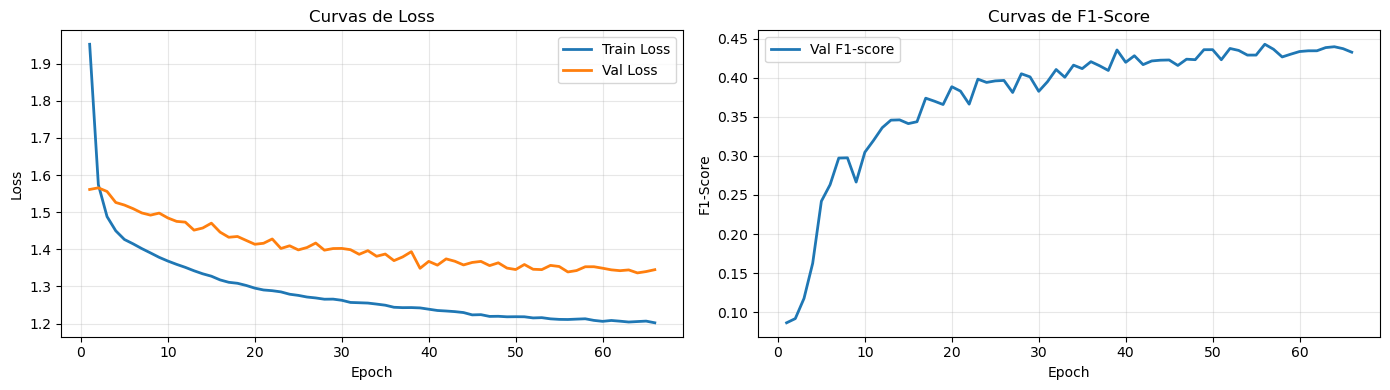

In [128]:
# Evaluar train

train_loss = model3.evaluate(X_train, y_train, verbose=0)

print(f"Train Loss: {train_loss:.4f}")

# Evaluar test

test_loss = model3.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")

# Visualización de curvas de entrenamiento
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Crear rango de epochs
epochs = range(1, len(history_model3.history['loss']) + 1)

# Loss
ax1.plot(epochs, history_model3.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs, history_model3.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curvas de Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, f1_callback.f1_scores, label='Val F1-score', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-Score')
ax2.set_title('Curvas de F1-Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Seguimos teniendo los mismos problemas 

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


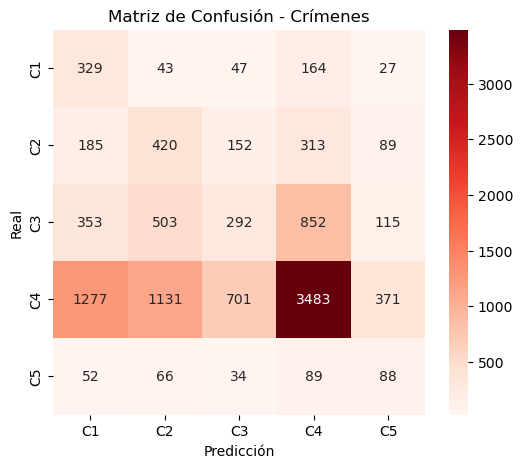


 Classification Report:
              precision    recall  f1-score   support

          C1       0.15      0.54      0.23       610
          C2       0.19      0.36      0.25      1159
          C3       0.24      0.14      0.17      2115
          C4       0.71      0.50      0.59      6963
          C5       0.13      0.27      0.17       329

    accuracy                           0.41     11176
   macro avg       0.28      0.36      0.28     11176
weighted avg       0.52      0.41      0.44     11176



In [129]:
# Matriz de confusión
y_pred_crime = model3.predict(X_test)
y_pred_crime_classes = np.argmax(y_pred_crime, axis=1)

cm = confusion_matrix(y_test, y_pred_crime_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[f"C{i+1}" for i in range(5)],
            yticklabels=[f"C{i+1}" for i in range(5)])
plt.title('Matriz de Confusión - Crímenes')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

print("\n Classification Report:")
print(classification_report(y_test, y_pred_crime_classes, 
                          target_names=[f"C{i+1}" for i in range(5)]))

# Evaluación general de todos los modelos